<a href="https://colab.research.google.com/github/chrisrutherford/biostats/blob/master/Final/Biostatistics_Lab_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install flashtorch
!pip install barbar

In [ ]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix

In [ ]:
drive.mount('/content/drive')

In [4]:
data_dir = '/content/drive/My Drive/Data/skin/'

In [5]:
dataset_labels =["benign", "malignant"] #<--- Replace with your labels 

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [7]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
dataset_sizes

{'train': 89, 'val': 22}

In [9]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

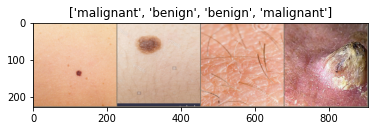

In [10]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [11]:
def train_model(model, num_epochs=25):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()  
        running_corrects = 0
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['val']))
        print("#######################")
    return model

In [12]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [13]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30
Train  Acc: 0.25
Valid  Acc: 0.50
#######################
Epoch:  2 / 30
Train  Acc: 0.72
Valid  Acc: 0.64
#######################
Epoch:  3 / 30
Train  Acc: 0.78
Valid  Acc: 0.73
#######################
Epoch:  4 / 30
Train  Acc: 0.81
Valid  Acc: 0.86
#######################
Epoch:  5 / 30
Train  Acc: 0.88
Valid  Acc: 0.77
#######################
Epoch:  6 / 30
Train  Acc: 0.90
Valid  Acc: 0.77
#######################
Epoch:  7 / 30
Train  Acc: 0.96
Valid  Acc: 0.77
#######################
Epoch:  8 / 30
Train  Acc: 0.89
Valid  Acc: 0.77
#######################
Epoch:  9 / 30
Train  Acc: 0.88
Valid  Acc: 0.77
#######################
Epoch:  10 / 30
Train  Acc: 0.93
Valid  Acc: 0.82
#######################
Epoch:  11 / 30
Train  Acc: 0.96
Valid  Acc: 0.82
#######################
Epoch:  12 / 30
Train  Acc: 0.92
Valid  Acc: 0.82
#######################
Epoch:  13 / 30
Train  Acc: 0.92
Valid  Acc: 0.82
#######################
Epoch:  14 / 30
Train  Acc: 0.94
Valid  Acc: 0.

In [14]:
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[preds[j]] + '     class: ' + dataset_labels[labels[j]]
            imshow(inputs.cpu().data[j],title1)

            if index == num_images:
                return

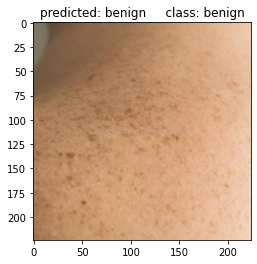

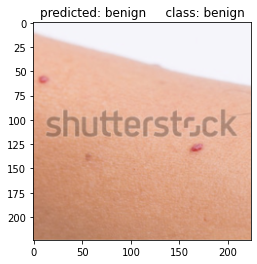

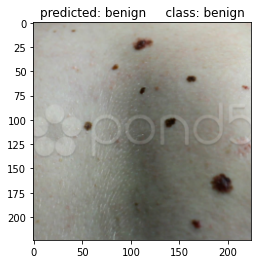

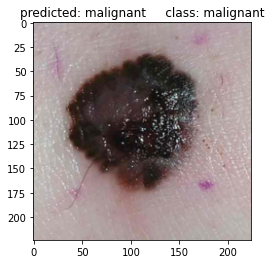

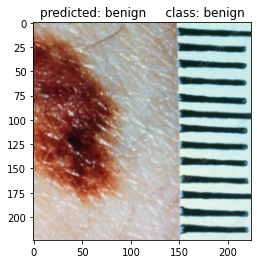

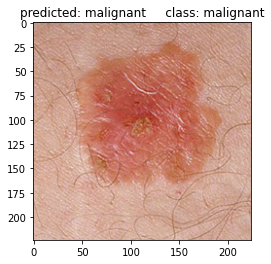

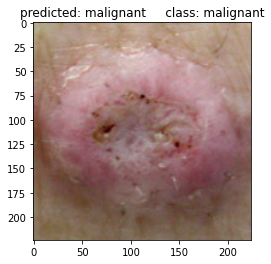

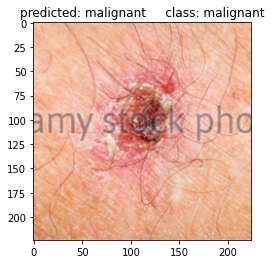

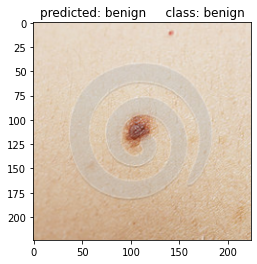

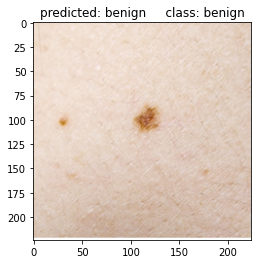

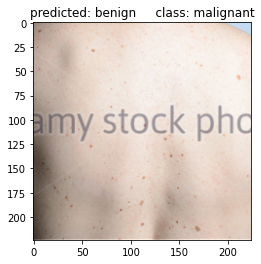

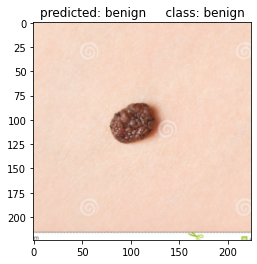

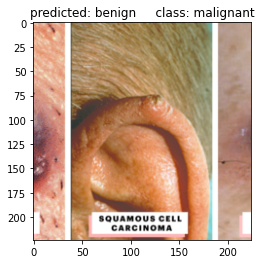

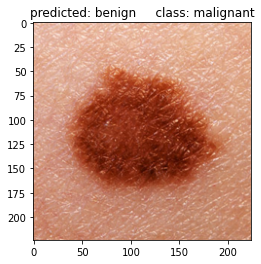

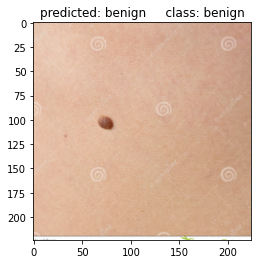

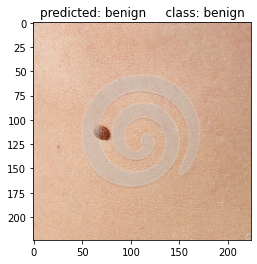

In [15]:
visualize_model(model)

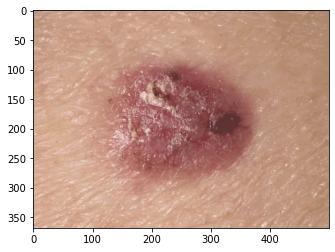

In [16]:
image = io.imread('https://www.merckmanuals.com/-/media/manual/home/images/basal_cell_carcinoma_b_high.jpg')
plt.imshow(image);

In [17]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [18]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [19]:
print('predicted: ' + dataset_labels[preds])

predicted: malignant


In [20]:
batch_size = 1024 #large batch size so we test all the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
inputs,labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)
labels = labels.detach().cpu().numpy()

In [22]:
outputs = model(inputs)
preds = torch.max(outputs, 1)[1].detach().cpu().numpy()

In [23]:
cm = confusion_matrix(preds.reshape(-1),labels)

In [33]:
print("Confusion Matrix:")
cm

Confusion Matrix:


array([[11,  4],
       [ 0,  7]])

In [38]:
print(str(cm[0,0])+" benign cases correctly classified (TN)")
print(str(cm[1,1])+" malignant cases correctly classified (TP)")
print(str(cm[0,1])+" malignant cases incorrectly classified as benign (FN)")
print(str(cm[1,0])+" benign cases incorrectly classified as malignant (FP)")

11 benign cases correctly classified (TN)
7 malignant cases correctly classified (TP)
4 malignant cases incorrectly classified as benign (FN)
0 benign cases incorrectly classified as malignant (FP)


Calculate each of the following:

Accuracy (ACC)
The percentage of correctly identified true and false samples.

True positive (TP)
The number of correctly identified samples. 

True negative (TN)
The number of correctly identified negative samples.
 
False positive (FP)
The number of wrongly identified samples, i.e., a commonly called a "false alarm". 
 
False negative (FN)
The number of wrongly identified negative samples. 

Recall (REC)
This metric is also frequently called sensitivity, probability of detection and true positive rate, and it is the ratio of samples that are correctly identified as positive among all existing positive samples.
 
Precision (PREC)
This metric is also frequently called the positive predictive value, and shows the ratio of samples that are correctly identified as positive.

Specificity (SPEC)
This metric is frequently called the true negative rate, and shows the ratio of negatives that are correctly identified as such.
 
F1 score (F1)
A measure of a test’s accuracy by calculating the harmonic mean of the precision and recall.


In [25]:
cm[0,0]

11

In [26]:
cm[1,1]

7

In [27]:
cm[0,1]

4

In [28]:
cm[1,0]

0

Accuracy

In [32]:
(cm[0, 0]+cm[1,1])/sum(sum(cm))

0.8181818181818182

TP Rate

In [39]:
cm[1,1]/(cm[1,1]+cm[0,1])

0.6363636363636364

TN Rate

In [41]:
cm[0,0]/(cm[0,0]+cm[1,0])

1.0

FP Rate

In [43]:
cm[1,0]/(cm[0,0]+cm[1,0])

0.0

Recall

In [49]:
recall = cm[1,1]/(cm[1,1]+cm[0,1])
recall

0.6363636363636364

Precision

In [50]:
prec = cm[1,1]/(cm[1,1]+cm[1,0])
prec

1.0

Specificity

In [46]:
cm[0,0]/(cm[0,0]+cm[1,0])

1.0

F1 Score

In [51]:
f1 = 2*(prec*recall)/(prec+recall)
f1

0.7777777777777778